In [417]:
import pandas as pd

In [418]:
hotels = pd.read_csv('hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [419]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

## Подготовка датасета к обучению

1. Закодируем национальность ревьюера

In [420]:
# кодируем национальность ревьюера методом бинарного кодирования
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками
data_bin = pd.DataFrame()
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
data_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, data_bin], axis=1)

2. Выделим из даты числовые коды

In [421]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['year'] = hotels['review_date'].dt.year
hotels['month'] = hotels['review_date'].dt.month
hotels['day'] = hotels['review_date'].dt.day
hotels.drop('review_date', axis = 1, inplace=True)

3. Обработаем поле days_since_review

In [422]:
# Выделим числовой признак из days_since_review
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda s: str.replace(s, ' days', ''))
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda s: str.replace(s, ' day', ''))
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda s: str.replace(s, 's', ''))
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda s: int(s))
hotels['days_since_review'] = hotels['days_since_review'].astype('int32')

4. закодируем страну расположения отеля

In [423]:
hotels['country'] = hotels['hotel_address'].apply(lambda s: s.split()[-1]) # выделяем признак страны отеля в отдельный столбец (последнее слово в строке адреса отеля)
# кодируем страну методом однократного кодирования, так как количество таких стран < 15
type_bin = pd.DataFrame()
encoder = ce.OneHotEncoder(cols=['country']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['country'])
hotels = pd.concat([hotels, type_bin], axis=1)

5. Закодируем отель

In [424]:
# кодируем имя отеля методом бинарного кодирования
type_bin = pd.DataFrame()
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, type_bin], axis=1)

6. Извлечем коды из отзывов

In [425]:
keyphrase_list = ['no positive',
                  'nothing',
                  'n a',
                  'na',
                  'none',
                  'non',
                  'all good',
                  'nothing really',
                  'no complaints',
                  'nil',
                  'nothing to dislike',
                  'nothing at all',
                  'everything was great',
                  'no',
                  'no nothing',
                  'everything was perfect',
                  'absolutely nothing',
                  'can t think of anything',
                  'nothing to complain about',
                  'leaving',
                  'nothing not to like',
                  'liked everything',
                  'having to leave',
                  'not much',
                  'everything was good',
                  'all was good',
                  'i liked everything',
                  'not applicable'
                  ]
#
def generate_no_negative_code(element):
    for i in keyphrase_list:
        if i == str.lower(str.strip(element)):
            return 1
    return 0
hotels['no_negative'] = hotels['negative_review'].apply(generate_no_negative_code)

In [426]:
keyphrase_list = ['everything',
                  'expensive'
                  ]
#
keyword_list = [  'price',
                  'staff',
                  'wifi',
                  'room',
                  'breakfast',
                  'bathroom',
                  'location',
                  'parking',
                  'cleanliness',
                  'position',
                  'pillows',
                  'bed'
                  ]
#
def generate_negative_code(element):
    for i in keyphrase_list:
        if i == str.lower(str.strip(element)):
            return 1
    for i in keyword_list:
        if i in str.lower(str.strip(element)):
            return 1
    return 0
hotels['negative'] = hotels['negative_review'].apply(generate_negative_code)

In [427]:
keyphrase_list = ['no positive',
                  'nothing',
                  'not much'
                  ]
#
def generate_code(element):
    for i in keyphrase_list:
        if i == str.lower(str.strip(element)):
            return 1
    return 0
hotels['no_positive'] = hotels['positive_review'].apply(generate_code)

In [428]:
keyphrase_list = ['everything',
                  'every thing',
                  'all'
                  ]
#
keyword_list = [  'price',
                  'staff',
                  'breakfast',
                  'location',
                  'parking',
                  'cleanliness',
                  'position',
                  'the bed'
                  ]
def generate_negative_code(element):
    for i in keyphrase_list:
        if i == str.lower(str.strip(element)):
            return 1
    for i in keyword_list:
        if i in str.lower(str.strip(element)):
            return 1
    return 0
hotels['positive'] = hotels['positive_review'].apply(generate_negative_code)

Опытным путем выяснилось, что признаки lat, lng не влияют на качество предсказания, их тоже удаляем

In [429]:
hotels.drop(['lat','lng'], axis = 1, inplace=True)

Модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим

In [430]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

## Обучение и тестирование модели

In [431]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [432]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [433]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [434]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [435]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13209246922695467


In [464]:
subm = y_test

In [462]:
subm['reviewer_score'] = y_pred

In [466]:
subm.info()

<class 'pandas.core.series.Series'>
Index: 96703 entries, 177225 to reviewer_score
Series name: reviewer_score
Non-Null Count  Dtype 
--------------  ----- 
96703 non-null  object
dtypes: object(1)
memory usage: 3.5+ MB


In [457]:
y_pred.to_csv('submission_booking_USV.csv', index = False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

Небольшой бонус:


In [436]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)

In [437]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [438]:
hotels.head(3)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,reviewer_nationality_0,reviewer_nationality_1,...,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,no_negative,negative,no_positive,positive
0,581,8.4,3,1994,4,7,10.0,531,0,0,...,0,0,0,0,0,1,1,0,0,1
1,299,8.3,3,1361,2,14,6.3,203,0,0,...,0,0,0,0,1,0,0,1,0,1
2,32,8.9,6,406,0,14,7.5,289,0,0,...,0,0,0,0,1,1,0,1,1,0


In [439]:
hotels = hotels.fillna(0)

Задание 4.1 (на самопроверку)
Дополните списки num_cols и cat_cols для оценки значимости всех признаков.

In [441]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 
            'review_total_negative_word_counts',
            'review_total_positive_word_counts',
            'additional_number_of_scoring', 
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'average_score'
            ]

# категориальные признаки
cat_cols = ['year','month','day',
            'reviewer_nationality_0',
            'reviewer_nationality_1',
            'reviewer_nationality_2',
            'reviewer_nationality_3',
            'reviewer_nationality_4',
            'reviewer_nationality_5',
            'reviewer_nationality_6',
            'reviewer_nationality_7',
            'country_1',
            'country_2',
            'country_3',
            'country_4',
            'country_5',
            'country_6',
            'no_positive',
            'positive',
            'no_negative',
            'negative'
            ]

<AxesSubplot:>

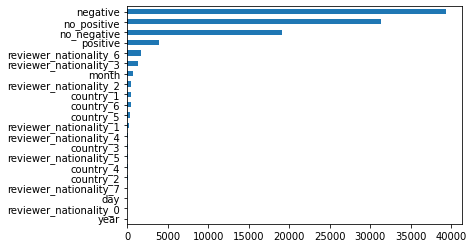

In [442]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

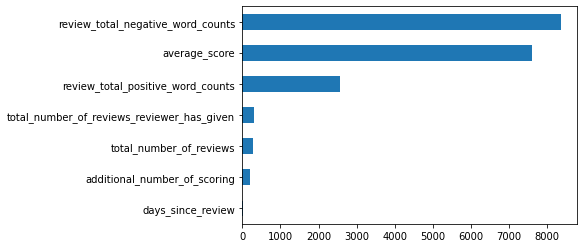

In [443]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Ответы на задания

In [444]:
hotels = pd.read_csv('hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


Задание 4.2
1 point possible (graded)
Сколько отелей представлено в наборе данных?

In [445]:
print('В наборе представлено уникальных отелей:', hotels['hotel_name'].unique().shape[0])

В наборе представлено уникальных отелей: 1492


Задание 4.3
2 points possible (graded)
Ответьте на вопросы о дате размещения отзывов.
Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.

In [446]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
print('Дата самого свежего отзыва:', hotels['review_date'].max())
print('Дата самого старого отзыва:',hotels['review_date'].min())

Дата самого свежего отзыва: 2017-08-03 00:00:00
Дата самого старого отзыва: 2015-08-04 00:00:00


Задание 4.4
1 point possible (graded)
Сколько уникальных тегов представлено в наборе данных?

In [447]:
# рассмотрим подробно структуру записей
hotels['tags']

0         [' Leisure trip ', ' Couple ', ' Studio Suite ...
1         [' Business trip ', ' Couple ', ' Standard Dou...
2         [' Leisure trip ', ' Solo traveler ', ' Modern...
3         [' Leisure trip ', ' Solo traveler ', ' Standa...
4         [' Business trip ', ' Couple ', ' Standard Dou...
                                ...                        
386798    [' Leisure trip ', ' Group ', ' Club Double or...
386799    [' Leisure trip ', ' Couple ', ' Standard Doub...
386800    [' Business trip ', ' Solo traveler ', ' Singl...
386801    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
386802    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 386803, dtype: object

In [448]:
# соберем тэги в множество, это позволит нам сразу отобрать уникальные тэги
unique_tags = set()
#
def choose_unique_tags(element):
    # функция сбора уникальных тэгов из строки
    global unique_tags
    element = str.replace(element, '[', '') # почистим строку от лишних символов
    element = str.replace(element, ']', '')
    element = str.replace(element, "' ", '')
    element = str.replace(element, " '", '')
    e_list = str.split(element, ', ') # разбиваем строку в список по запятым
    for i in range(len(e_list)): # добавляем в множество уникальные элементы из списка
        unique_tags.add(e_list[i])
#
hotels['tags'].apply(choose_unique_tags); # обработаем столбец функцией сбора тэгов
print('Количество уникальных тегов в наборе: ', len(unique_tags))

Количество уникальных тегов в наборе:  2368


Задание 4.5
1 point possible (graded)
Какой тег представлен в наибольшем числе отзывов?

In [449]:
# составим из множества словарь, где ключами будут теги, а значениями - количество упоминаний (начальное значение = 0)
unique_tags_dict = dict.fromkeys(unique_tags, 0)
#
def search_dictkeys_in_string(element): 
    # функция поиска в строке ключей внешнего словаря
    global unique_tags_dict
    #
    for i in unique_tags_dict.keys():
        if i in element:
            new_val = unique_tags_dict[i] + 1
            unique_tags_dict.update({i:new_val}) # в случае нахождения тэга в строке увеличиваем значение в словаре на 1
#
hotels['tags'].apply(search_dictkeys_in_string); # обработаем столбец с тэгами функцией поиска

In [450]:
# uniq_tags_dict = dict(sorted(uniq_tags_dict.items(), key=lambda item: item[1]))
tags_df = pd.DataFrame.from_dict(unique_tags_dict,  orient='index', columns=['count'])
tags_df.sort_values(by='count').tail(1)

,count
Leisure trip,313593


Задание 4.6
1 point possible (graded)
Из тегов выясните, на сколько ночей чаще всего останавливаются путешественники в отелях.

In [451]:
# максимальное количество ночей в тегах (зачем искал, не знаю :)
keyword = ' nights' # ключевое слово для поиска количества ночей
max_nights = 0 # счетчик максимального
#
keys_list = list(unique_tags_dict.keys())
for el in keys_list:
    if keyword in el:
       number_nights = int(el[el.find(keyword)- 2:el.find(keyword)])
       max_nights = number_nights if number_nights > max_nights else max_nights
max_nights

30

In [452]:
tags_df = tags_df.reset_index()
tags_df = tags_df.rename(columns={'index':'tag'})
tags_df

,tag,count
0,Superior Room with Queen Bed and Sofa,43
1,Prestige Twin Room,4
2,Tradition Double Room,63
3,Accessible Twin Room,42
4,Souterraine Double or Twin Room,110
...,...,...
2363,Double Room Tour Eiffel with Shower,11
2364,Spring Package Deluxe Double or Twin Room,25
2365,Standard Twin Room 2 Adults 1 Child,6
2366,Grand Deluxe King or Twin Room,52


In [453]:
# найдем на сколько ночей чаще всего останавливаются путешественники в отелях
# для этого пробежим по датафрейму, найдем записи содержащие ключевое слово "nights" и определим запись с максимальным количеством упоминаний
keyword = 'night' # ключевое слово
max_cases = 0 # сюда запишем максимальное кол-во записей, содержащих ключевое слово
max_tag = '' # сюда запишем текст тега
#
counter = tags_df.shape[0] # установим счетчик для цикла - размер датафрейма с уникальными тегами
#
for i in range(counter):
    if tags_df['tag'].iloc[i].find(keyword) > -1: # условие нахождения ключевого слова в строке тэга
        if tags_df['count'].iloc[i] > max_cases:
            max_cases  = tags_df['count'].iloc[i]
            max_tag    = tags_df['tag'].iloc[i]
print('Наиболее часто упоминаемый тэг, содержащий информацию о количестве ночей пребывания: ', max_tag)

Наиболее часто упоминаемый тэг, содержащий информацию о количестве ночей пребывания:  Stayed 1 night
